## Exploratory Data Analysis

In-distribution train/dev vs. out-of-distribution test for ASL-Alphabet.

- **Train** and **Dev**: same person/background; 400 images/class in **Dev**
- **Test**: different people/backgrounds, 100 images/class, 2 classes empty


In [40]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import mediapipe as mp
from sklearn.decomposition import PCA
import pandas as pd

from utils import get_image_paths_and_labels

TRAIN_DIR = 'data/asl_alphabet_train'
DEV_DIR = 'data/asl_alphabet_dev'
TEST_DIR = 'data/synthetic_test'

seed = 42
random.seed(seed)
np.random.seed(seed)

train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
dev_paths, dev_labels = get_image_paths_and_labels(DEV_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

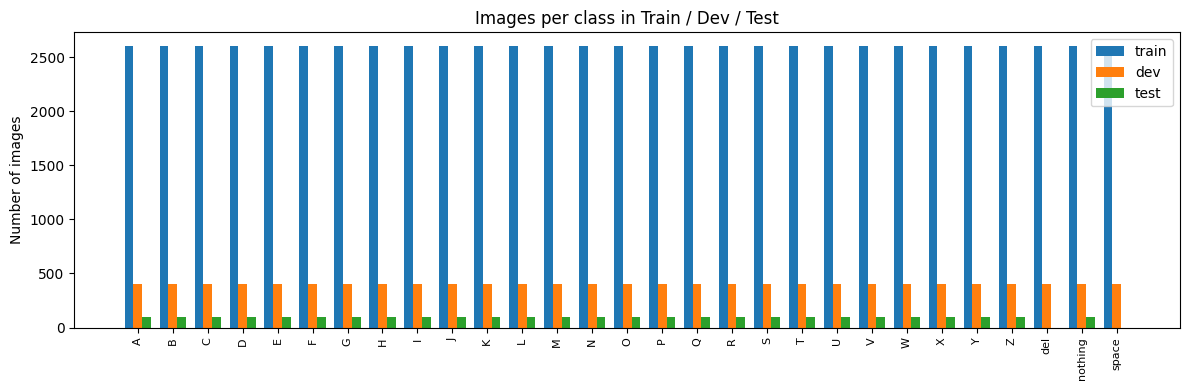

In [41]:
label_to_name = {}
for path, lbl in zip(train_paths, train_labels):
    if lbl not in label_to_name:
        label_to_name[lbl] = os.path.basename(os.path.dirname(path))
# ensure sorted by label
class_ids = sorted(label_to_name)
class_names = [label_to_name[i] for i in class_ids]


# count per split
def count_per_class(labels: np.ndarray) -> np.ndarray:
    return np.bincount(labels, minlength=len(class_ids))


counts = {
    'train': count_per_class(train_labels),
    'dev': count_per_class(dev_labels),
    'test': count_per_class(test_labels),
}

df_counts = pd.DataFrame(counts, index=class_names)

# plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 4))
x = np.arange(len(class_names))
w = 0.25
for i, split in enumerate(df_counts.columns):
    ax.bar(x + (i - 1) * w, df_counts[split], width=w, label=split)

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=90, fontsize=8)
ax.set_ylabel("Number of images")
ax.set_title("Images per class in Train / Dev / Test")
ax.legend()
plt.tight_layout()
plt.show()

We can see that the classes are represented uniformly in all 3 sets, but the 'del' and 'space' classes are missing form **test**

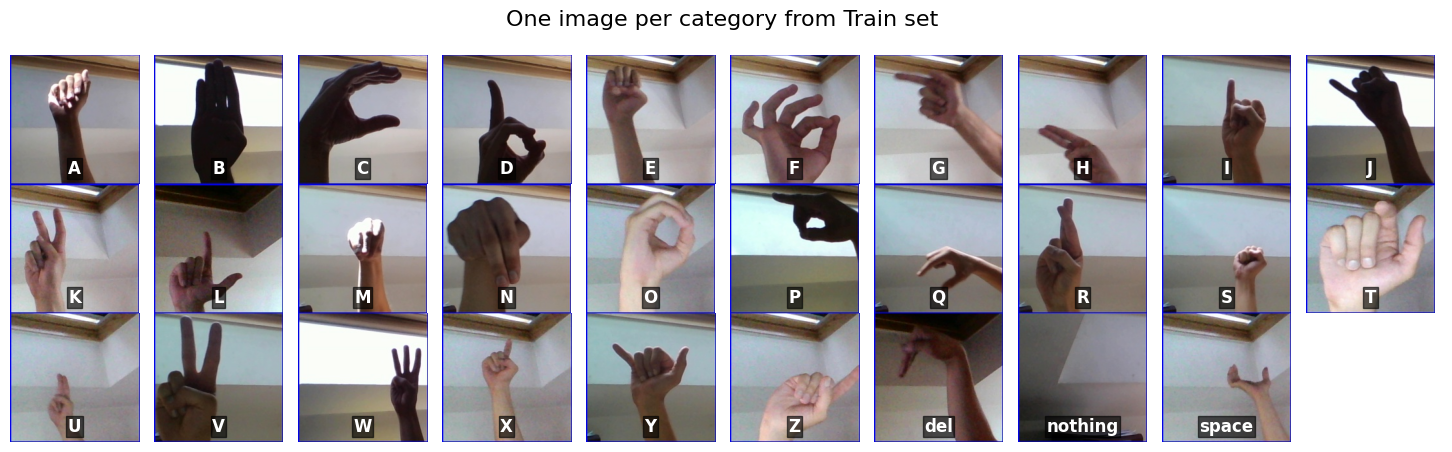

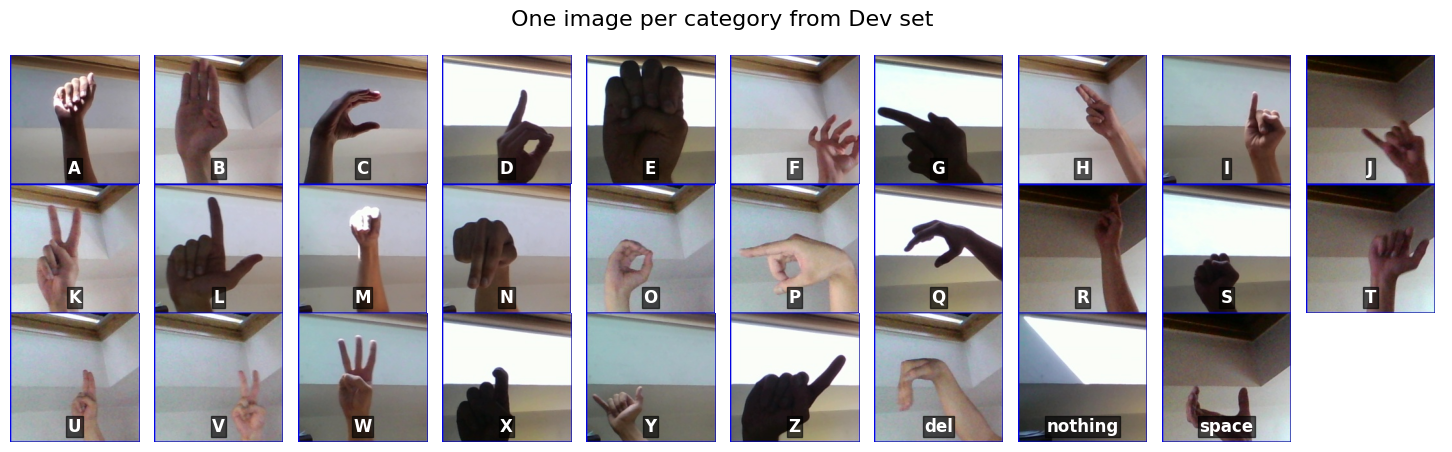

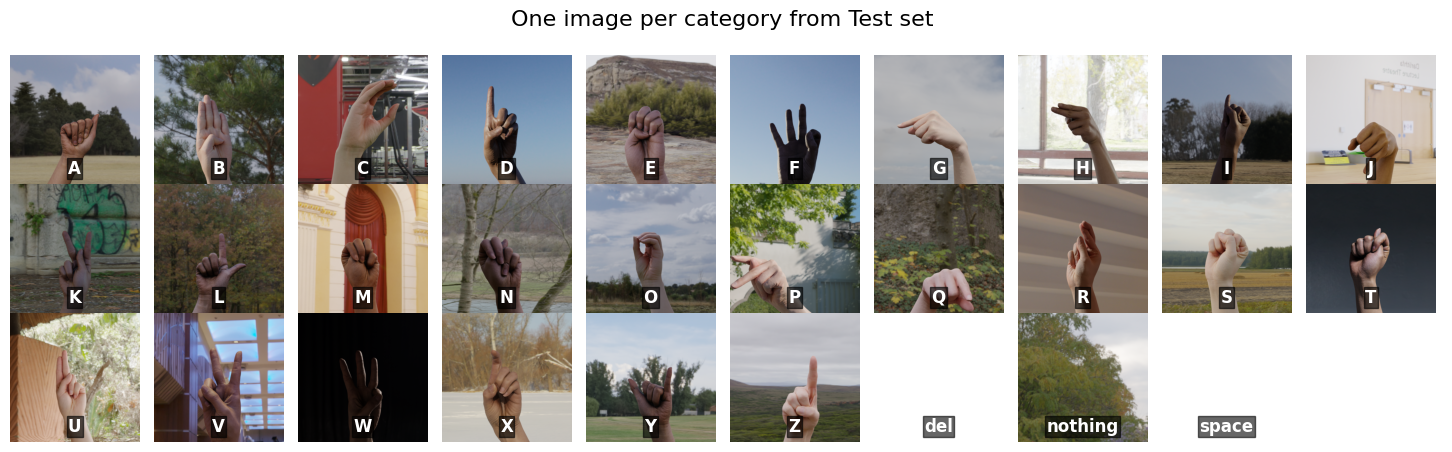

In [42]:
# Cell 4: One-sample-per-class grids with no intra-grid spacing

import math

splits_data = [
    ('Train', train_paths, train_labels),
    ('Dev', dev_paths, dev_labels),
    ('Test', test_paths, test_labels),
]

n_cols = 10
n_classes = len(class_names)
n_rows = math.ceil(n_classes / n_cols)  # 3 rows for ~32 classes

for split_name, paths, labels in splits_data:
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(n_cols * 1.5, n_rows * 1.5),
    )
    # remove all spacing
    plt.subplots_adjust(
        left=0.02, right=0.98,
        top=0.88, bottom=0.02,
        wspace=0, hspace=0,
    )
    fig.suptitle(f"One image per category from {split_name} set", fontsize=16)

    # draw each class tile
    for idx, cls in enumerate(class_names):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]

        # find any image of this class
        cid = class_ids[class_names.index(cls)]
        idxs = [i for i, y in enumerate(labels) if y == cid]
        if idxs:
            img = Image.open(paths[random.choice(idxs)])
            ax.imshow(img)
        else:
            # grey background for missing class
            ax.set_facecolor('#444444')

        ax.axis('off')
        # overlay class letter
        ax.text(
            0.5, 0.05, cls,
            transform=ax.transAxes,
            ha='center', va='bottom',
            color='white', fontsize=12, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.6, pad=1)
        )

    # turn off any extra axes (if total tiles > n_classes)
    total_tiles = n_rows * n_cols
    for extra in range(n_classes, total_tiles):
        r = extra // n_cols
        c = extra % n_cols
        axes[r, c].axis('off')

    plt.show()


We can see the same background and person in the **Train** and **Dev** sets. Whereas the **Test** set contains different persons and backgrounds.

The **Train** and **Dev** sets only contain right hands, but the **Test** set contains left hands as well

It is also true that there are at most one hand per image, and the hands are in the middle of the image.

Some letters, like M, N, G and P look really different; but most letters are somewhat similar between the **Test/Dev** and **Train** sets

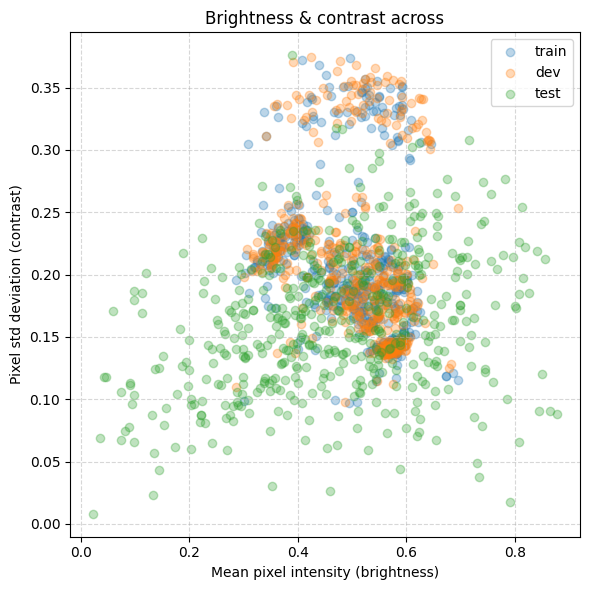

In [43]:
def pixel_stats(paths, n=500):
    idxs = list(range(len(paths)))
    random.Random(seed).shuffle(idxs)
    chosen = [paths[i] for i in idxs[:n]]
    means, stds = [], []
    for p in chosen:
        arr = np.asarray(Image.open(p).convert('L').resize((64, 64)), np.float32) / 255.0
        means.append(arr.mean())
        stds.append(arr.std())
    return np.array(means), np.array(stds)


m_tr, s_tr = pixel_stats(train_paths)
m_de, s_de = pixel_stats(dev_paths)
m_te, s_te = pixel_stats(test_paths)

plt.figure(figsize=(6, 6))
plt.scatter(m_tr, s_tr, alpha=0.3, label='train')
plt.scatter(m_de, s_de, alpha=0.3, label='dev')
plt.scatter(m_te, s_te, alpha=0.3, label='test')
plt.xlabel("Mean pixel intensity (brightness)")
plt.ylabel("Pixel std deviation (contrast)")
plt.title("Brightness & contrast across")
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


**Dev** and **Train** overlap almost perfectly, this means consistent lighting/contrast.

**Test** spans wider: some very dark/flat images (low mean & low std), others very bright/high‐contrast.